\title{Assignment CA4 - Real Estate Pricing} \author{Aditya Dey} \maketitle

Kaggle ID: Adiityadey

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Exploration 

In [2]:
raw = pd.read_csv("train.csv").set_index("Unnamed: 0")
print("Shape of train dataset: {}".format(raw.shape))

test = pd.read_csv("test.csv").set_index("Unnamed: 0")
print("Shape of test dataset: {}".format(test.shape))

Shape of train dataset: (11543, 15)
Shape of test dataset: (1230, 14)


## Assessing Correlation between Features

<AxesSubplot:>

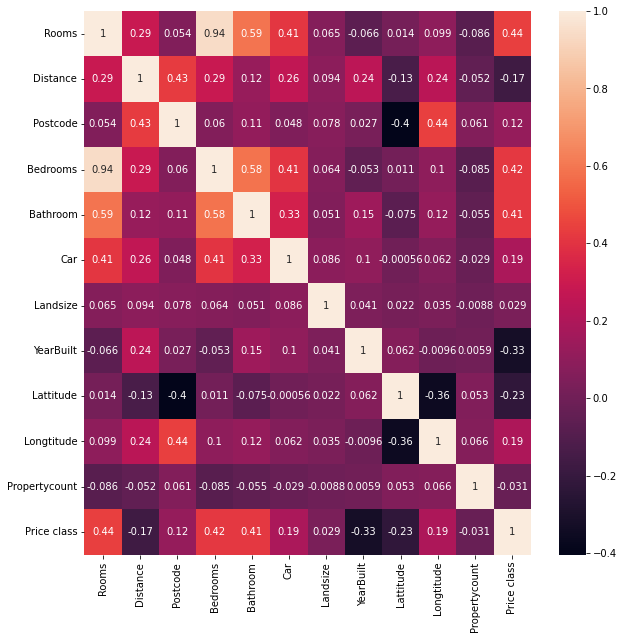

In [3]:
plt.figure(figsize=(10,10))
sns.heatmap(raw.corr(), annot=True,)

- There is a significantly high correlation of 0.94 between Bedrooms and Rooms which implies they are correlated, i.e. Rooms information may consist information of Bedrooms too. Also the correlation between Rooms(0.44) and Price Class is slightly higher than Bedrooms(0.42) which may signify Rooms do have strength in determining the Price Class.

- There is slightly good correlation of 0.59 between Bathroom and Rooms.

Thus based on correlation values \textbf{we are dropping "Bedrooms" feature} due to significantly high correlation with "Rooms".

In [4]:
raw.drop(["Bedrooms"], axis=1, inplace=True)
test.drop(["Bedrooms"], axis=1, inplace=True)

## Pairplot visualisation

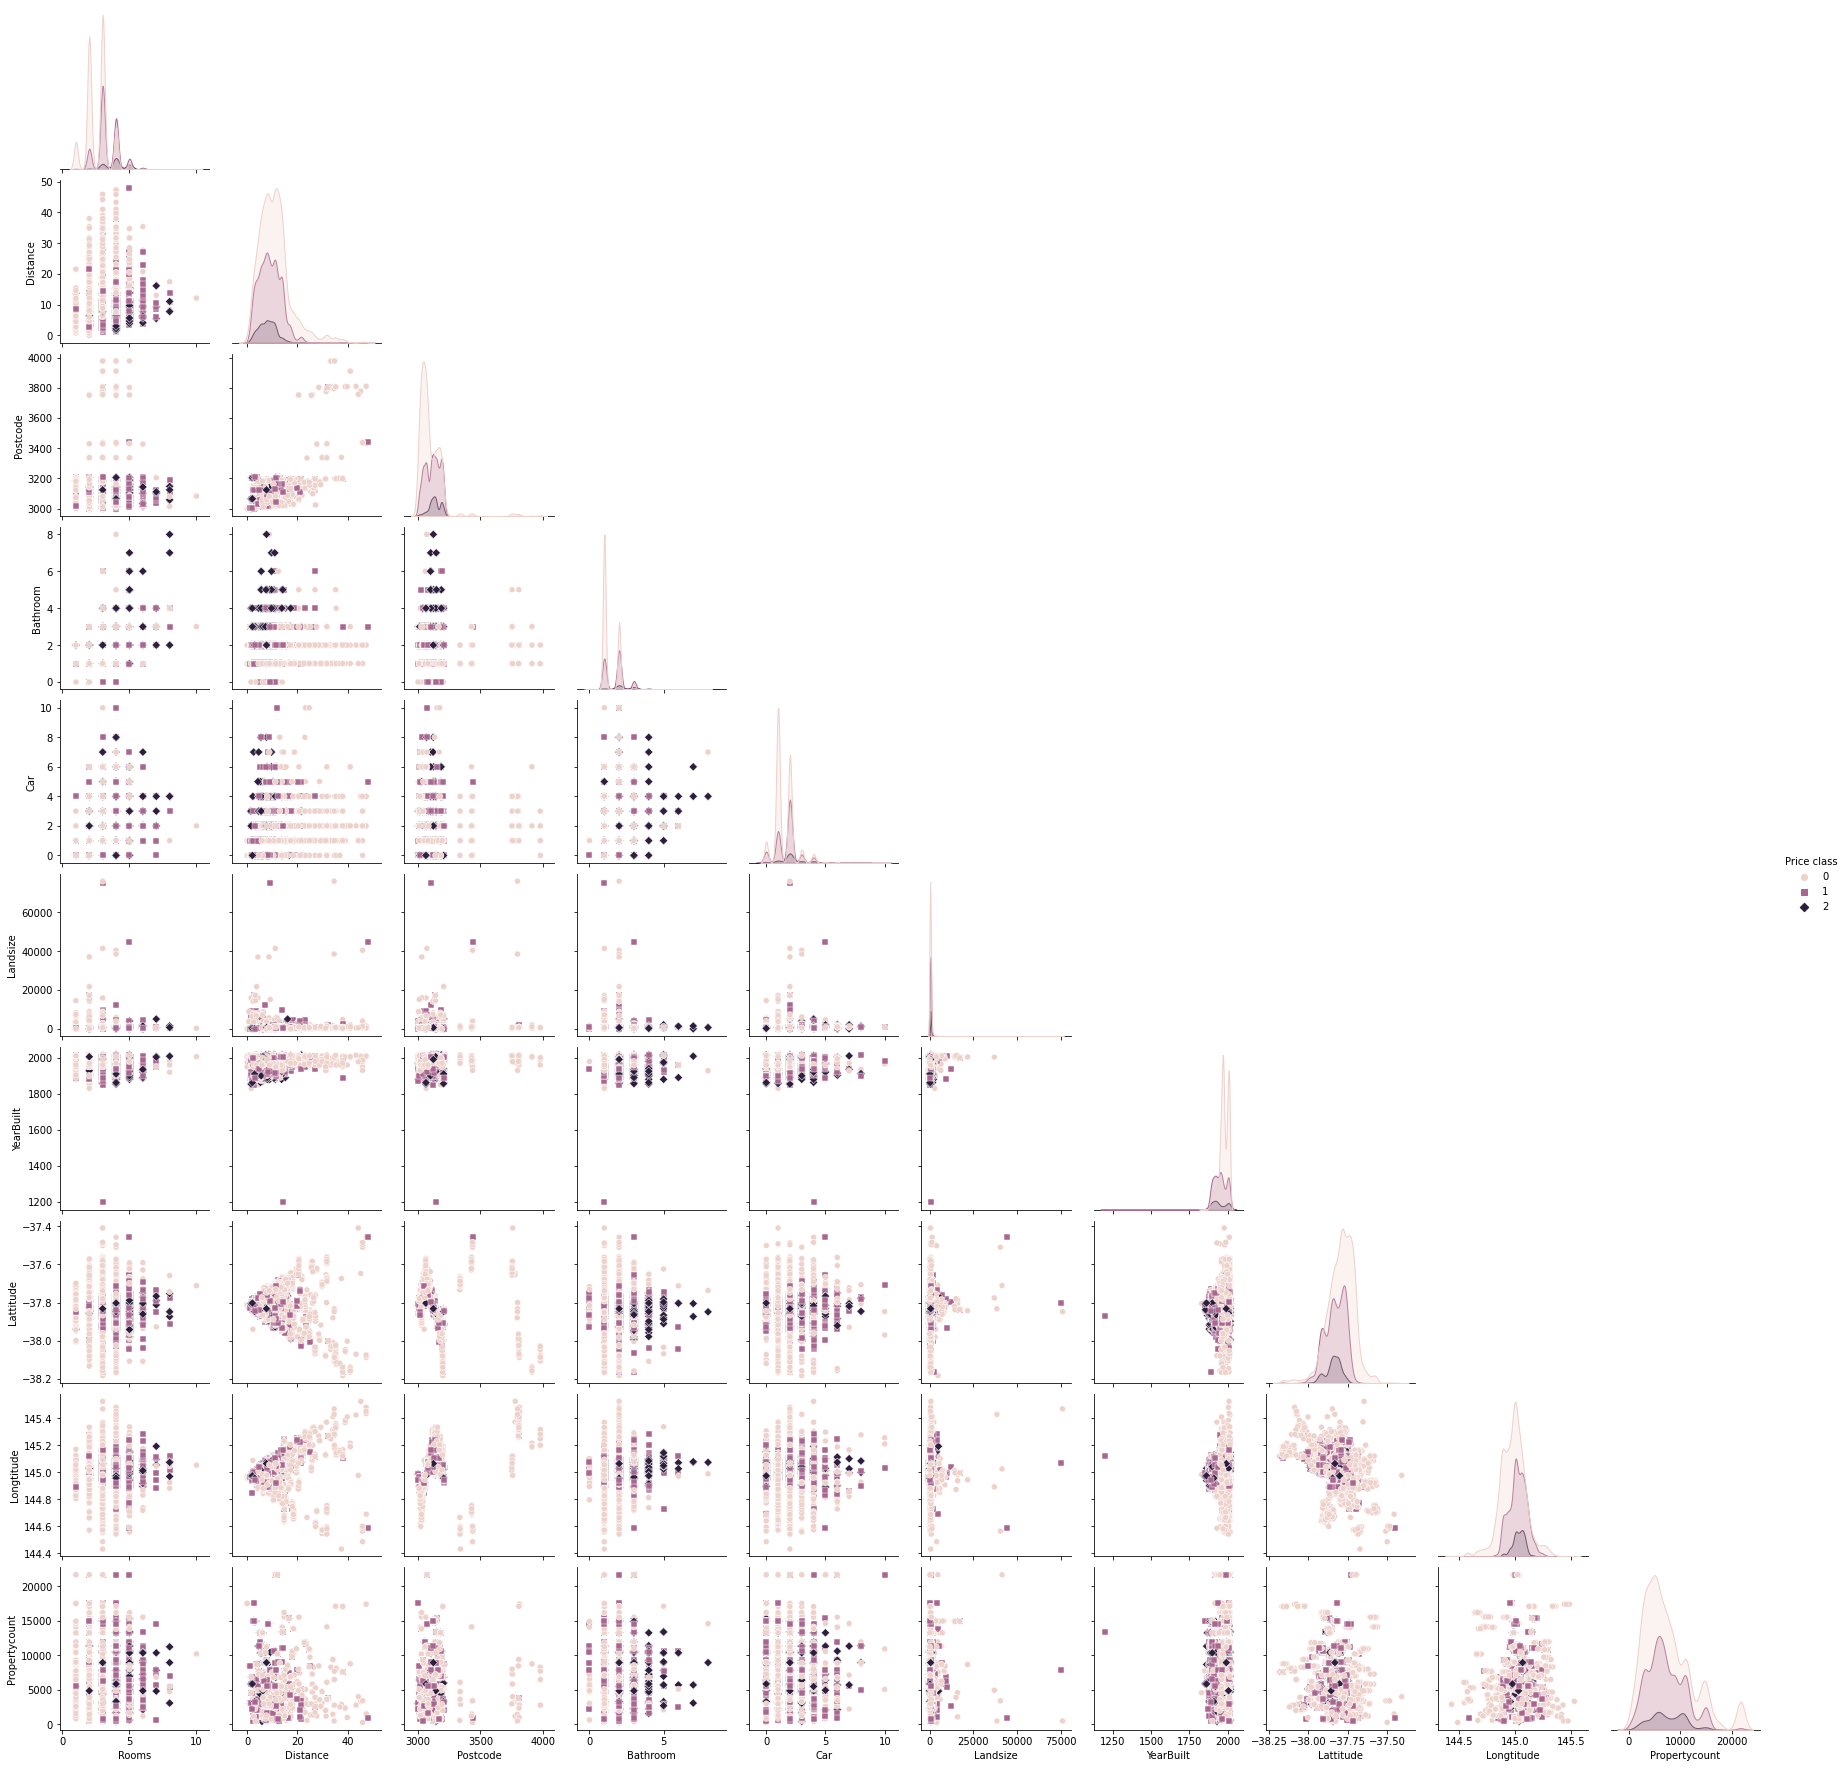

In [5]:
sns.pairplot(raw, hue="Price class", markers=["o", "s", "D"], corner=True)

All of the above pairplots have overlapping regions for all 3 classes therefore linear boundary of seperation will not work and if model is created it will tend to have poor accuracy score. Principal Component Analysis and Kernel PCA may be necessary for this dataset.

# Data Cleansing 

## Nominal Feature Conversion

In [6]:
df = raw.copy()


#Training Data

# Performing nominal feature conversion to numerical with pandas dummies(similar to OneHotEncoder)
df_Type = pd.get_dummies(df["Type"], prefix = "Type")
df_Method = pd.get_dummies(df["Method"], prefix = "Type")
df_Region = pd.get_dummies(df["Regionname"], prefix = "Region")


# Dropping duplicate features
new_df = pd.concat([df, df_Type, df_Method,df_Region], axis=1)
new_df.drop(["Type","Method","Regionname"],axis=1,inplace=True)
new_df.columns

# Rearranging columns
df1 = new_df[['Rooms', 'Distance', 'Postcode', 'Bathroom', 'Car',
       'Landsize', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount',
        'Type_h', 'Type_t', 'Type_u', 'Type_PI', 'Type_S',
       'Type_SA', 'Type_SP', 'Type_VB', 'Region_Eastern Metropolitan',
       'Region_Eastern Victoria', 'Region_Northern Metropolitan',
       'Region_Northern Victoria', 'Region_South-Eastern Metropolitan',
       'Region_Southern Metropolitan', 'Region_Western Metropolitan',
       'Region_Western Victoria', 'Price class']]


In [7]:
# Performing similar on Testing Data
t_Type = pd.get_dummies(test["Type"], prefix = "Type")
t_Method = pd.get_dummies(test["Method"], prefix = "Type")
t_Region = pd.get_dummies(test["Regionname"], prefix = "Region")
new_test = pd.concat([test, t_Type, t_Method,t_Region], axis=1)
new_test.drop(["Type","Method","Regionname"],axis=1,inplace=True)

## Removing Outliers

In [8]:
#Qunatile below threshold values will be removed.
Q1 = df1.quantile(q=0.10)
Q3 = df1.quantile(q=0.90)

#Interquantile Range
IQR = Q3 - Q1

df2 = df1[~((df1 <(Q1 - 1.5*IQR)) | (df1 >(Q3 + 1.5*IQR))).any(axis=1)]
print("Outliers removed: {}".format(df1.shape[0] - df2.shape[0]))

Outliers removed: 2703


## Handling Missing Values

During experimentation it is found that filling np.nan with median strategy provides better outcome than mean strategy.

The reason is mean tends to fill with central value whereas median tries to fill with most occured central value. For example for YearBuilt feature the mean is 1964.4982 and median is 1970.0 implying there are more number of lower years causing the mean to be lower than median. And the median implies there are more number of properties built around 1970 than in other years.


In [9]:
df2.isna().sum().loc[lambda x: x>0]

Bathroom           34
Car                38
Landsize           27
YearBuilt        3592
Propertycount      33
dtype: int64

In [10]:
# Note: Using SimpleImputer created problems in final submission thus using the below method.
values = df2.median()
df2 = df2.fillna(values)

# Creating and Testing Model

## Splitting Train and Test Data from Training Data

In [11]:
from sklearn.model_selection import train_test_split

# Training Data
X = df2.iloc[:,:-1].values
y = df2.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1, stratify=y, test_size=0.3)
print("Shape of train data: {}".format(X_train.shape))
print("Shape of test data: {}".format(X_test.shape))


# Final Test Data
Xtest = new_test.iloc[:,:].values

Shape of train data: (6188, 26)
Shape of test data: (2652, 26)


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

## Logistic Regression Testing

In [13]:
# LogR without PCA
pipe_lr1 = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, solver='liblinear'))

param_grid_lr1 = [{'logisticregression__C':[0.01,100],
                 'logisticregression__max_iter': [100],
                  'logisticregression__penalty': ['l1','l2']}]

gs_lr1 = GridSearchCV(estimator=pipe_lr1, cv=10, scoring="accuracy", param_grid=param_grid_lr1)

# LogR with PCA 
pipe_lr2 = make_pipeline(StandardScaler(),PCA(random_state=1), \
                         LogisticRegression(random_state=1, solver='liblinear'))

param_grid_lr2 = [{'pca__n_components':[20,25],
                   'logisticregression__C':[0.01,100],
                 'logisticregression__max_iter': [100],
                  'logisticregression__penalty': ['l1','l2']}]
gs_lr2 = GridSearchCV(estimator=pipe_lr2, cv=10, scoring="accuracy", param_grid=param_grid_lr2)


In [14]:
gs_lr1 = gs_lr1.fit(X_train, y_train)
gs_lr2 = gs_lr2.fit(X_train,y_train)

print("LogR without PCA Best Score: {}".format(gs_lr1.best_score_))
print("LogR without PCA Parameters: {} \n".format(gs_lr1.best_params_))
print("LogR with PCA Best Score: {}".format(gs_lr2.best_score_))
print("LogR with PCA Parameters: {}".format(gs_lr2.best_params_))

LogR without PCA Best Score: 0.8143213032817311
LogR without PCA Parameters: {'logisticregression__C': 100, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l1'} 

LogR with PCA Best Score: 0.8143213032817311
LogR with PCA Parameters: {'logisticregression__C': 100, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l1', 'pca__n_components': 20}


- Above results indicates a Logistic Classifier does not gain any significant accuracy by PCA.
- Even though C=100 gives best train accuracy, test accuracy has to be lower because C represents inverse of regularization strength, i.e. the regularization strength of this model is very low which will not be able to penalize larger weights computed thus causing overfitting leading to inaccurate predictions.

## Support Vector Machines Testing

In [15]:
"""c_param_range = [10,100]
gamma_param_range = [0.01, 0.001]

#With PCA
pipe_svc2 = make_pipeline(StandardScaler(), PCA(n_components=20, random_state=1), SVC(kernel="rbf", random_state=1))
param_grid_svc2 = [{'svc__C': c_param_range, 
                    'svc__gamma': gamma_param_range}]
gs_svc2 = GridSearchCV(estimator=pipe_svc2, param_grid=param_grid_svc2, scoring='accuracy', cv=10 )

#With KernelPCA
pipe_svc3 = make_pipeline(StandardScaler(), KernelPCA(random_state=1), SVC(kernel="rbf", random_state=1))
param_grid_svc3 = [{'kernelpca__n_components':[20,25],
                    'kernelpca__gamma': gamma_param_range,
                    'svc__C': c_param_range, 
                    'svc__gamma': gamma_param_range}]
gs_svc3 = GridSearchCV(estimator=pipe_svc3, param_grid=param_grid_svc3, scoring='accuracy', cv=10 )"""

'c_param_range = [10,100]\ngamma_param_range = [0.01, 0.001]\n\n#With PCA\npipe_svc2 = make_pipeline(StandardScaler(), PCA(n_components=20, random_state=1), SVC(kernel="rbf", random_state=1))\nparam_grid_svc2 = [{\'svc__C\': c_param_range, \n                    \'svc__gamma\': gamma_param_range}]\ngs_svc2 = GridSearchCV(estimator=pipe_svc2, param_grid=param_grid_svc2, scoring=\'accuracy\', cv=10 )\n\n#With KernelPCA\npipe_svc3 = make_pipeline(StandardScaler(), KernelPCA(random_state=1), SVC(kernel="rbf", random_state=1))\nparam_grid_svc3 = [{\'kernelpca__n_components\':[20,25],\n                    \'kernelpca__gamma\': gamma_param_range,\n                    \'svc__C\': c_param_range, \n                    \'svc__gamma\': gamma_param_range}]\ngs_svc3 = GridSearchCV(estimator=pipe_svc3, param_grid=param_grid_svc3, scoring=\'accuracy\', cv=10 )'

In [16]:
"""gs_svc2 = gs_svc2.fit(X_train,y_train)
gs_svc3 = gs_svc3.fit(X_train, y_train)

print("SVM without PCA Best Score: {}".format(gs_svc2.best_score_))
print("SVM without PCA Parameters: {} \n".format(gs_svc2.best_params_))
print("SVM with KernelPCA Best Score: {}".format(gs_svc3.best_score_))
print("SVM with KernelPCA Parameters: {}".format(gs_svc3.best_params_))"""

'gs_svc2 = gs_svc2.fit(X_train,y_train)\ngs_svc3 = gs_svc3.fit(X_train, y_train)\n\nprint("SVM without PCA Best Score: {}".format(gs_svc2.best_score_))\nprint("SVM without PCA Parameters: {} \n".format(gs_svc2.best_params_))\nprint("SVM with KernelPCA Best Score: {}".format(gs_svc3.best_score_))\nprint("SVM with KernelPCA Parameters: {}".format(gs_svc3.best_params_))'

Note: This classifier takes long time and I cannot run it again. Thus I am giving my results directly.

Best Params for SVC:
- C = 100, gamma = 0.01, pca n_components = 20, accuracy = ~0.84
- C = 100, gamma = 0.01, kernelpca n_components = 20, accuracy = ~0.84

C is the inverse regularization strength so having 100 is like lowering it and gamma or Cut off Parameter has to be lower since higher value will overfit the boundaries.

Also pca components are not 3,5 or 10 but 20 since each columns explained_variance_ratio is (0.19,0.16,0.10,0.09,...) therefore it needs more components to  be able to predict accurately.

## Random Forest Testing

In [24]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Without PCA
pipe_rf1 = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1))
param_grid_rf1 = [{'randomforestclassifier__n_estimators': [5,10,15,20,25]}]
gs_rf1 = GridSearchCV(estimator=pipe_rf1, param_grid = param_grid_rf1, scoring='accuracy', cv=10)

#Random Forest With PCA
pipe_rf2 = make_pipeline(StandardScaler(), PCA(random_state=1), RandomForestClassifier(random_state=1))
param_grid_rf2 = [{'pca__n_components': [15,20,25],
                    'randomforestclassifier__n_estimators': [5,10,15,20, 25]}]
gs_rf2 = GridSearchCV(estimator=pipe_rf2, param_grid = param_grid_rf2, scoring='accuracy', cv=10)

In [25]:
gs_rf1 = gs_rf1.fit(X_train, y_train)
gs_rf2 = gs_rf2.fit(X_train,y_train)


print("RF without PCA Best Score: {}".format(gs_rf1.best_score_))
print("RF without PCA Parameters: {} \n".format(gs_rf1.best_params_))
print("RF without PCA Best Score: {}".format(gs_rf2.best_score_))
print("RF without PCA Parameters: {} \n".format(gs_rf2.best_params_))

RF without PCA Best Score: 0.8531031886694794
RF without PCA Parameters: {'randomforestclassifier__n_estimators': 20} 

RF without PCA Best Score: 0.826438142739882
RF without PCA Parameters: {'pca__n_components': 20, 'randomforestclassifier__n_estimators': 20} 



This clearly shows RandomForest does not need PCA for better accuracy, rather PCA has reduced accuracy by ~2%.

The Final Model is Random Forest Classifier without PCA and n_estimators as 20 since its training score is the best compared to SVM and LogisticRegression.


In [26]:
# Using Random Forest Classifier without PCA and n_estimators = 20 as final model.
clf = gs_rf1.best_estimator_
y_pred = clf.predict(X_test)

In [27]:
pred_df = pd.DataFrame(y_pred, columns=(['Price class']))
pred_df = pred_df.reset_index()
pred_df.to_csv("Submission.csv", index = False)

# Confusion Matrix

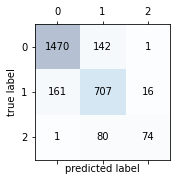

In [28]:
from sklearn.metrics import confusion_matrix 


y_pred = clf.predict(X_test)
conf_mat = confusion_matrix(y_true =y_test, y_pred= y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

# 5 Fold Cross Validation with ROC

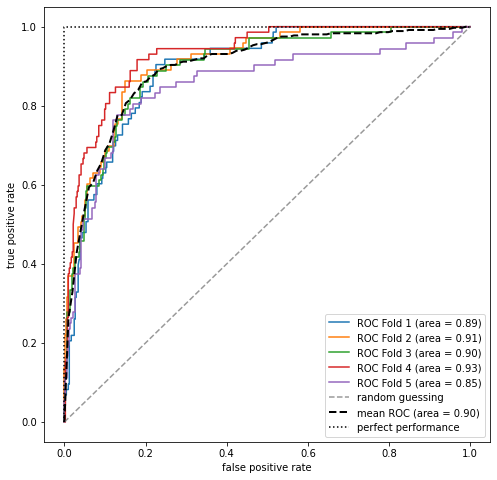

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

roc_df = df2.query("`Price class` in (1,2)")

X = roc_df.iloc[:,:-1].values
y = roc_df.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y, test_size=0.3)

pipe_svc = make_pipeline(StandardScaler(), PCA(n_components=20, random_state=1),\
                         SVC(C=100, gamma=0.01, random_state=1, kernel='rbf', probability=True))

# pipe_rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=25, random_state=1))

cv = list(StratifiedKFold(n_splits=5, random_state=1, shuffle=True).split(X_train, y_train))


fig = plt.figure(figsize=(8,8))
mean_tpr = 0.0
mean_fpr = np.linspace(0,1,100)

all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_svc.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:,1], pos_label=2)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'ROC Fold %d (area = %0.2f)'%(i+1, roc_auc))
    
plt.plot([0, 1],[0, 1],linestyle='--',color=(0.6, 0.6, 0.6), label='random guessing')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],[0, 1, 1],linestyle=':',color='black',label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")
plt.show()
    